In [ ]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
# import netwulf as nw
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json
from nltk import PorterStemmer, bigrams as nltk_bigrams
import re
from nltk.corpus import stopwords

sns.set_style("darkgrid")

REVIEW_DATA_FILE = 'Movies_and_TV.jsonl'
META_DATA_FILE = "meta_Movies_and_TV.jsonl"

NETWORK_FILE = "movie_network.json"

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

# TODO
Map all review asin to same movie

In [105]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

### Load and Filtering of Data

In [154]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()

In [252]:
df.limit(5)

rating,asin,user_id,timestamp,text,community
f64,str,str,i64,str,i64
5.0,"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""This DVD was GREAT! I am a st…",null
3.0,"""B000PIU2A0""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,"""this item was canceled. . . .n…",null
5.0,"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,"""I grew up with this one. could…",12
4.0,"""B000TSMOEI""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088147000,"""like watching: haven't gotten …",null
4.0,"""B0009MAO82""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364087577000,"""pretty cool to watch: differen…",null


In [108]:
df.height, df.get_column("asin").n_unique()

(2888210, 409673)

In [109]:
def filter_reviews(df, movie_threshold=5, review_threshold=5):
    prev_rows = -1
    while df.height != prev_rows:
        prev_rows = df.height
        valid_movies = (
            df.group_by('asin')
            .agg(pl.col('user_id').n_unique().alias('count'))
            .filter(pl.col('count') >= review_threshold)
            .get_column('asin')
        )
        df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

        valid_reviewers = (
            df.group_by('user_id')
            .agg(pl.col('asin').n_unique().alias('count'))
            .filter(pl.col('count') >= movie_threshold)
            .get_column('user_id')
        )
        df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
    return df

filtered_df = filter_reviews(df)

In [159]:
reviewer_counts = (
    filtered_df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500)
)
reviewer_counts_count = reviewer_counts.height
reviewer_counts_count

2

In [160]:
filtered_df.height, filtered_df.get_column("asin").n_unique()

(289311, 28569)

In [294]:
schema = {
    "main_category": pl.Utf8,
    "title": pl.Utf8,
    # "subtitle": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    # "features": pl.List(pl.Utf8),
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,  # intentionally string to avoid parse issues like "from 2.99"
    # "store": pl.Null,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
        # pl.Field("Audio languages", pl.List(pl.Utf8)),
        # pl.Field("Subtitles", pl.List(pl.Utf8)),
        # pl.Field("Directors", pl.List(pl.Utf8))
    ]),
    "parent_asin": pl.Utf8,
    # "bought_together": pl.Null
}

df_meta = pl.read_ndjson(META_DATA_FILE, schema=schema)

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

df_meta.limit(5)

main_category,title,average_rating,rating_number,description,price,categories,content_advisory,parent_asin,desc_len
str,str,f64,i64,str,f64,list[str],list[str],str,u32
"""Prime Video""","""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""Prime Video""","""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",null,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""Movies & TV""","""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Prime Video""","""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Prime Video""","""Ben 10: Alien Force (Classic)""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [296]:
df_meta.filter(pl.col("title") == "Glee")
# df_meta.get_column("title").n_unique()

main_category,title,average_rating,rating_number,description,price,categories,content_advisory,parent_asin,desc_len
str,str,f64,i64,str,f64,list[str],list[str],str,u32
"""Prime Video""","""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""Prime Video""","""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B009ARMP7U""",396
"""Prime Video""","""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B009LZEZSI""",396
"""Prime Video""","""Glee""",4.7,1843,"""Entering its sophomore season,…",19.59,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""alcohol use"", … ""sexual content""]","""B00463U1LK""",258
"""Prime Video""","""Glee""",4.7,1843,"""Entering its sophomore season,…",19.59,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""alcohol use"", … ""sexual content""]","""B004P1BYNC""",258
…,…,…,…,…,…,…,…,…,…
"""Prime Video""","""Glee""",4.6,2617,"""The highly anticipated first s…",19.99,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]",[],"""B003LWLIS2""",1208
"""Prime Video""","""Glee""",4.7,2005,"""Entering its fourth season, th…",19.59,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B009ARMS1I""",396
"""Prime Video""","""Glee""",4.7,2005,"""Entering its fourth season, th…",19.59,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B009LZHRCO""",396


In [300]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("parent_asin").unique().alias("all_parent_asins"),
        pl.first("main_category"),
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("desc_len"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
)

best_per_title

title,all_parent_asins,main_category,average_rating,rating_number,description,desc_len,price,categories,content_advisory
str,list[str],str,f64,i64,str,u32,f64,list[str],list[str]
"""Lake Placid 3 / Lake Placid Vs…","[""B095GNM33B""]","""Movies & TV""",4.2,54,"""""",0,20.2,"[""Movies & TV"", ""Genre for Featured Categories"", ""Action & Adventure""]",[]
"""Hidden Kingdoms (Original UK V…","[""B00JFH8GMI""]","""Movies & TV""",4.3,78,"""Hidden Kingdoms (Blu-ray)""",25,7.33,"[""Movies & TV"", ""Blu-ray"", ""Movies""]",[]
"""Uncommon Bach - Music Experien…","[""B000Q6GWOQ""]","""Movies & TV""",3.4,7,"""Product Description""",19,29.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Music Videos & Concerts""]",[]
"""Heaven's Gate""","[""B07TFD23P7"", ""B00005M1SL""]","""Prime Video""",4.0,1417,"""This ambitious frontier epic f…",175,null,"[""Western"", ""Adventure"", … ""Gritty""]","[""Nudity"", ""violence"", … ""sexual content""]"
"""American Dad Vol. 5""","[""B003CN5B7E""]","""Movies & TV""",4.8,663,"""Product Description""",19,14.23,"[""Movies & TV"", ""Studio Specials"", … ""All Fox Titles""]",[]
…,…,…,…,…,…,…,…,…,…
"""Carol Burnett Show: This Time …","[""B00AGMT7MY""]","""Movies & TV""",4.4,218,"""Carol Burnett Thi(6D)""",21,11.88,"[""Movies & TV"", ""Boxed Sets"", ""Comedy""]",[]
"""Outer Limits:Production & Deca…","[""6301977130""]","""Movies & TV""",4.4,217,"""""",0,null,"[""Movies & TV"", ""Genre for Featured Categories"", ""Drama""]",[]
"""Seven Days (2007)""","[""B003P0TX8C""]","""Movies & TV""",3.7,19,"""""",0,23.99,"[""Movies & TV"", ""Featured Categories"", … ""Action & Adventure""]",[]


In [299]:
best_per_title.filter(pl.col("title") == "Glee")

title,all_parent_asins,main_category,average_rating,rating_number,description,desc_len,price,categories,content_advisory
str,list[str],str,f64,i64,str,u32,f64,list[str],list[str]
"""Glee""","[""B005JR3UP6"", ""B009ARMS1I"", … ""B002Q91AVG""]","""Prime Video""",4.6,2617,"""The highly anticipated first s…",1208,19.99,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]",[]


In [302]:
asin_title_map = best_per_title.select([
    pl.col("title"),
    pl.col("all_parent_asins")
]).explode("all_parent_asins").rename({
    "all_parent_asins": "asin"
})

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

In [303]:
df_reviews

rating,asin,user_id,timestamp,text,community,title
f64,str,str,i64,str,i64,str
5.0,"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""This DVD was GREAT! I am a st…",null,"""10 Minute Solution: Pilates"""
3.0,"""B000PIU2A0""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,"""this item was canceled. . . .n…",null,"""Battlespace"""
5.0,"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,"""I grew up with this one. could…",12,"""Columbo: Mystery Movie Collect…"
4.0,"""B000TSMOEI""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088147000,"""like watching: haven't gotten …",null,"""Burst Angel: Hired Gun v.4"""
4.0,"""B0009MAO82""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364087577000,"""pretty cool to watch: differen…",null,"""Burst Angel, Vol. 3: East Meet…"
…,…,…,…,…,…,…
4.0,"""B003QL7KAI""","""AHKU4VS2OB3AWD6GUUBDG3AHFHVA""",1445999724000,"""Had already seen the film. Int…",null,"""Ride the Divide"""
5.0,"""B006R0A7AK""","""AEHONQ4HRSHEX33KZ2QAEBEIWUAQ""",1447698497000,"""Eye opening. Definitely on my …",null,null
5.0,"""B00014K5CI""","""AGKN36N7C3AGAV6SJZGDXMTZHLVA""",1437155829000,"""I ordered this for my 11 year …",null,"""Saturday Night Live - 25th Ann…"


### Network

In [112]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = Counter()

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [113]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer:   0%|          | 0/29578 [00:00<?, ?it/s]

Reviewer: 100%|██████████| 29578/29578 [00:02<00:00, 10648.91it/s]


3380500

In [ ]:
thresholds = [2,3,4,5,7,10]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w >= t]
    print(f"Edges with weight => {t}: {len(weighted_edges)}")

Edges with weight => 4: 6344
Edges with weight => 5: 3276
Edges with weight => 7: 1288
Edges with weight => 10: 493
Edges with weight => 15: 150


### Graph

In [115]:
WEIGHT_THRESHOLD = 2
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

115364

In [116]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
save_graph(NETWORK_FILE, G)

c:\Users\rdh\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [117]:
len(G.nodes()), len(G.edges())

(21586, 115364)

In [118]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

10.68877976466228

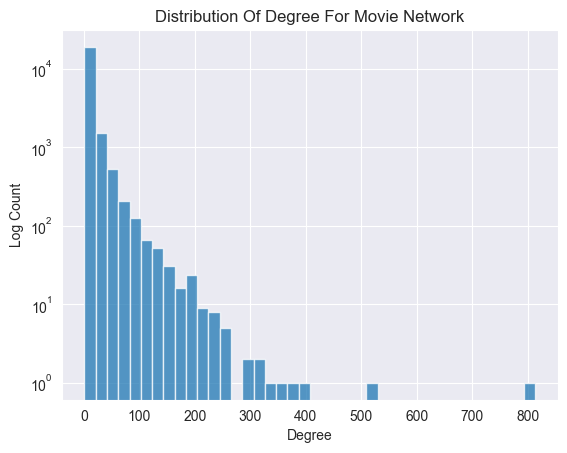

In [119]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

In [140]:
len(largest)

5128

In [ ]:
# from pyvis.network import Network

# net = Network(notebook=True)
# net.from_nx(G)
# net.show("graph.html")

largest = max(communities, key=len)
H = G.subgraph(largest)

nx.draw(H, node_size=10, with_labels=False)

### Community detection

In [120]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [201]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [202]:
communities = louvain_partitions(G)
len(communities)

370

In [123]:
modularity(G, communities) 

0.7445071193762218

In [174]:
X = list(map(len, communities))
# X = [x for x in X if x < 100]
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

### Text analysis

In [ ]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in df.columns:
    df = df.drop("community")

df = df.join(community_df, on="asin", how="left")

In [ ]:
# Tokenize and stemming reviews
stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

In [170]:
# movie_data.get_column("community").n_unique()
# movie_data.filter(pl.col("community") == 350)

movie,degree,community
str,i64,i64
"""0783227876""",1,350
"""B0007OCG5Q""",1,350
